In [3]:
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re

## Connect to db

In [4]:
# connect to mysql database

mydb = mysql.connector.connect(
    host="localhost",
    user="root",
    passwd="",
    database="halofilkom_db"
)

print(mydb)

In [5]:
# create cursor object
mycursor = mydb.cursor()

## Ambil semua data mahasiswa bertanya

In [6]:
# sql = "SELECT body FROM ost_thread_entry WHERE recipients is null"
# mycursor.execute(sql)
# questionsAll = mycursor.fetchall()

In [7]:
# questionsAll = [x[0] for x in questionsAll]

In [8]:
# len(questionsAll)

### Cleaning data

#### Stopword preparation

In [9]:
# nltk.download('punkt', quiet=True)
# listStopword = set(nltk.corpus.stopwords.words('indonesian'))
# listStopword.add('assalamualaikum')
# listStopword.add('waalaikumsalam')
# listStopword.add('wassalamualaikum')
# listStopword.add('salam')
# listStopword.add('halo')
# listStopword.add('menjawab')
# listStopword.add('bapak/ibu')
# listStopword.add('bapak')
# listStopword.add('ibu')
# listStopword.add('mengganggu')
# listStopword.add('sekian')
# listStopword.add('mohon')
# listStopword.add('maaf')
# listStopword.add('prodi')
# listStopword.add('mahasiswa')
# listStopword.add('terimakasih')
# listStopword.add('terhormat')
# listStopword.add('filkom')
# listStopword.add('universitas')
# listStopword.add('indonesia')
# listStopword.add('nim')
# listStopword.add('agastya')

In [10]:
# def clean(text):
#     text = text.lower()
#     text = text.replace('\u200b', '')
#     text = re.sub('<.*?>', '', text)

#     tokens = nltk.tokenize.word_tokenize(text.lower())
#     tokens = [t for t in tokens if t not in listStopword]
#     tokens = [t for t in tokens if t.isalpha()]
#     tokens = [t.strip() for t in tokens if len(t) > 2]
#     text = " ".join(tokens)
#     text = text.replace('selamat pagi','')
#     text = text.replace('selamat siang','')
#     text = text.replace('selamat sore','')
#     text = text.replace('terima kasih','')
#     text = text.replace('teknik informatika','')
#     text = text.replace('teknik komputer','')
#     text = text.replace('sistem informasi','')
#     text = text.replace('teknologi informasi','')
#     text = text.replace('pendidikan teknologi informasi','')
#     text = text.replace('fakultas ilmu komputer','')
#     text = text.split(' ')
#     text = " ".join(text)

#     return text.strip()

In [11]:
# for i in range(len(questionsAll)):
#     questionsAll[i] = clean(questionsAll[i])
    

#### Remove duplicate

In [12]:
# #remove duplicate
# questionsAll = list(dict.fromkeys(questionsAll))

#### Export to txt

In [13]:
# # export to txt file
# with open('questions.txt', 'w') as f:
#     for item in questionsAll:
#         f.write(item + "\n")

## Take data from txt

In [14]:
# txt to list
with open('questions_cleaned.txt', 'r') as f:
    questions = f.read().splitlines()

# Get canned response

## Ambil semua data dari canned response

In [15]:
# mycursor.execute("SELECT * FROM `ost_canned_response`")
# result = mycursor.fetchall()

In [16]:
# # import sql result to pandas dataframe
# import pandas as pd
# df = pd.DataFrame(result)
# df.drop(columns=[0,1,2,5,6,7,8],inplace=True) #drop kolom yang tidak diperlukan
# df.columns = ['topik','jawaban']
# df.head(10)

## Cleaning data

In [17]:
# df['jawaban'] = df['jawaban'].apply(lambda x: x.
#                                     replace('<p>','').
#                                     replace('</p>','').
#                                     replace('<ol>','').
#                                     replace('</ol>','').
#                                     replace('<li>','').
#                                     replace('</li>','').
#                                     replace('<ul>','').
#                                     replace('</ul>','').
#                                     replace('<br>','').
#                                     replace('br','').
#                                     replace('<strong>','').
#                                     replace('</strong>','').
#                                     replace('<em>','').
#                                     replace('</em>','').
#                                     replace('<a href="','').
#                                     replace('">','').
#                                     replace('</a>','').
#                                     replace('<img src="','').
#                                     replace('" alt="','').
#                                     replace('" />','').
#                                     replace('< />','')
#                                     )

In [18]:
# print(df.loc[2]['topik'])
# print(df.loc[2]['jawaban'])

## export to csv

In [19]:
# # exxport dataframe to csv
# df.to_csv('jawaban.csv', index=False)

In [20]:
# import re

# index_df = 15
# full_text = re.sub(r'[^\w\s]', '', df['topik'][index_df].upper())+", "+ df['jawaban'][index_df].lower()
# full_text = full_text.strip()
# full_text

## read csv

In [21]:
# Import csv to dataframe
import pandas as pd
df = pd.read_csv('jawaban_cleaned.csv')

In [22]:
df

,topik,jawaban
0,Keuangan - Pengajuan Bantuan Keuangan,Pengajuan Bantuan Keuangan dapat mengisi form ...
1,Keuangan - Pencairan Saldo UKT,Silahkan mengajukan permohonan pencairan saldo...
2,keuangan - cek siam untuk tagihan,"Update Tagihan pada SIAM sdra, apabila Besaran..."
3,Keuangan - Kriteria 50%,Kriteria yang mendapat bantuan 50% adalah bagi...
4,Registrasi Mahasiswa Lama,Berikut kami informasikan Registrasi Mahasiswa...
...,...,...
119,Akademik Alur Pasca Ujian Skripsi,Panduan mahasiswa telah lulus Ujian Skripsi ;1...
120,Akademik_Mhs Kritis Ujian sblm 21-07-2022 Yudi...,"Terimakasih telah menghubungi HaloFilkom,-Bagi..."
121,Akademik Ujian Skripsi 2021-2 ; Pendaftaran yu...,"Terima Kasih telah menghubungi halo filkom, Ba..."
122,Akademik_templates DTIF,"Terima Kasih telah menghubungi halo filkom,Ber..."


In [ ]:
for topik in df['topik']:
    judul_topik = re.sub(r'[^\w\s]', '', topik)
    judul_topik = judul_topik.lower().replace('keuangan','').replace('kemahasiswaan','').replace('akademik','').strip()
    judul_topik = judul_topik.replace('_',' ')

# Eksperimen

## Experiment with n=3

In [23]:
import yake

data = []

def extract_keywords(text):
    keywords = yake.KeywordExtractor(lan="en ", n=3)
    return keywords.extract_keywords(text)[0][0]

for i in range(len(df)):
    judul_topik = re.sub(r'[^\w\s]', '', df['topik'][i])
    judul_topik = judul_topik.lower().replace('keuangan','').replace('kemahasiswaan','').replace('akademik','').strip()
    judul_topik = judul_topik.replace('_',' ')
    full_text = judul_topik+", "+ df['jawaban'][i].lower()
    full_text = full_text.strip()
    data.append([judul_topik,extract_keywords(full_text).lower()])

dfKeywords = pd.DataFrame(data,columns=['topik','keywords'])
dfKeywords

,topik,keywords
0,pengajuan bantuan,pengajuan bantuan keuangan
1,pencairan saldo ukt,"bebas,rapi dan sopan"
2,cek siam untuk tagihan,apabila besaran nominal
3,kriteria 50,adalah bagi mahasiswa
4,registrasi mahasiswa lama,registrasi mahasiswa lama
...,...,...
119,alur pasca ujian skripsi,filkom apps masing
120,mhs kritis ujian sblm 21072022 yudisium,penerbitan skl dll
121,ujian skripsi 20212 pendaftaran yudisium non ...,sesuai edaran dekan
122,templates dtif,terima kasih telah


In [24]:
dfKeywords['keywords']

0      pengajuan bantuan keuangan
1            bebas,rapi dan sopan
2         apabila besaran nominal
3           adalah bagi mahasiswa
4       registrasi mahasiswa lama
                  ...            
119            filkom apps masing
120            penerbitan skl dll
121           sesuai edaran dekan
122            terima kasih telah
123          mohon mahasiswa bisa
Name: keywords, Length: 124, dtype: object

In [25]:
dfKeywords.to_csv('keywords_n3.csv', index=False)

In [26]:
def cari_pertanyaan(index):
    keywords = dfKeywords['keywords'][index]
    daftarPertanyaan = [l for l in questions if keywords in l]
    return daftarPertanyaan

In [27]:
questions[2]

'nalan ridlo fadhilah   perihal pengangsuran ukt semester ganjil keringan membayar pengangsuran ukt semester ganjil terkendala covid'

In [28]:
data = []

for i in range(len(dfKeywords)):
    result = cari_pertanyaan(i)
    for res in result:
        data.append([dfKeywords['topik'][i],res])

dfPertanyaan = pd.DataFrame(data,columns=['topik','pertanyaan'])
dfPertanyaan.shape

(126, 2)

In [29]:
index = 10
print(dfPertanyaan['topik'][index])
print(dfPertanyaan['pertanyaan'][index])

pengajuan bantuan
lampirkan surat pengajuan bantuan keuangan bantuannya


### Analisa Hasil

In [30]:
dfPertanyaan

,topik,pertanyaan
0,pengajuan bantuan,informasi jadwal pengajuan bantuan keuangan me...
1,pengajuan bantuan,pengajuan bantuan keuangan kategori penguranga...
2,pengajuan bantuan,sbg informasi pengumuman kelulusan hasil selek...
3,pengajuan bantuan,proses pengajuan bantuan keuangan error form d...
4,pengajuan bantuan,akumulasi angsuran semester angsuran semester ...
...,...,...
121,kkn 2020,tata tertib uas tertulis wajib krs semester ge...
122,kkn 2020,rencana pembayaran sdra lakukan melebihi tangg...
123,kkn 2020,surat edaran kkn juni sosialisasi kkn juni jun...
124,ujian skripsi 20212 pendaftaran yudisium non ...,akademik perkenalkan aqmal maulana tisno mene...


In [31]:
print(dfKeywords['keywords'].unique().shape[0])
print(dfPertanyaan['topik'].unique().shape[0])
print()
print((dfPertanyaan['topik'].unique().shape[0]) / (dfKeywords['keywords'].unique().shape[0]) * 100)

107
19

17.75700934579439


In [32]:
dfg = dfPertanyaan.groupby('topik').count().sort_values(by='pertanyaan',ascending=False)
dfg

,pertanyaan
topik,
surat aktif kuliah,23
pengambilan sertifikat toefl,19
pendaftaran yudisium filkom ub,18
pengajuan bantuan,15
kkn 2020,11
bantuan ukt dan ukt kemendikbud ristek,8
pendataan kelas penuh,7
permohonan perpanjangan mahasiswa do diluar skripsi,7
dosen pembimbing ujian skripsi tidak hadir salah satu,5


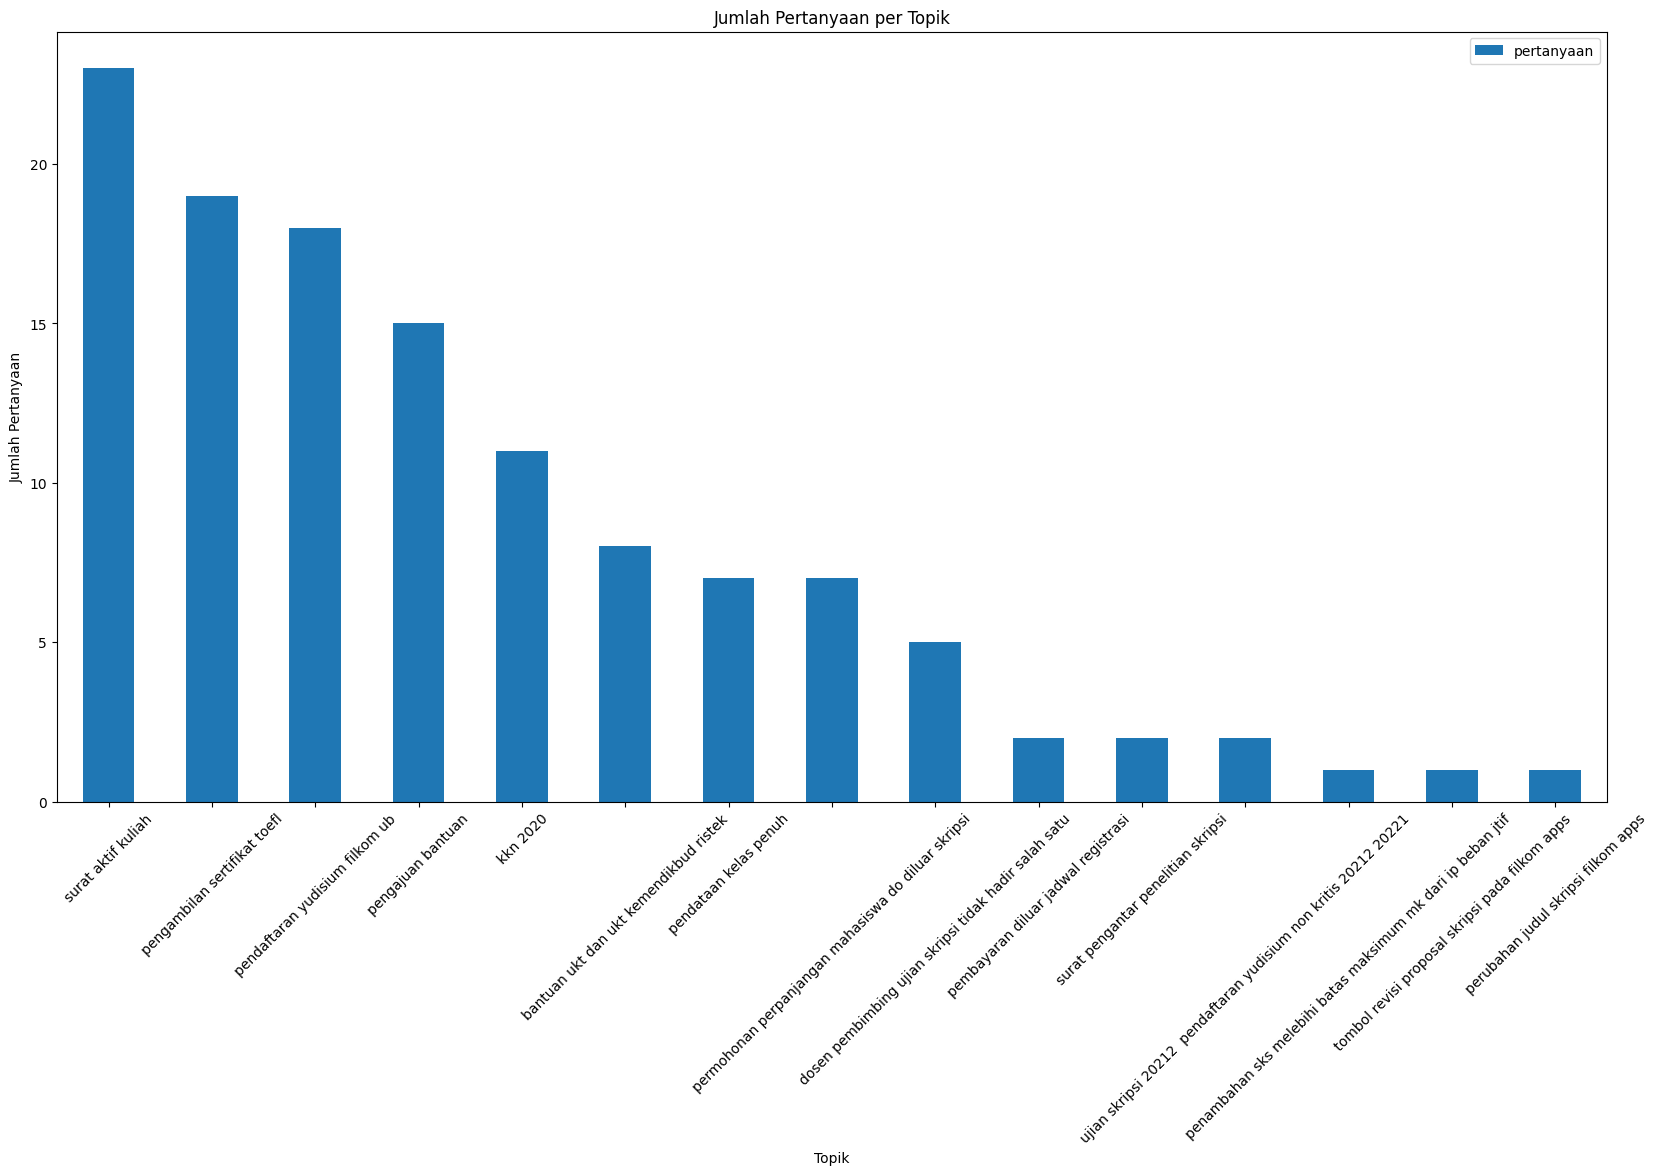

In [33]:
dfp = dfg.head(15).plot(kind='bar',
            figsize=(20,10),
            title='Jumlah Pertanyaan per Topik',
            xlabel='Topik',
            ylabel='Jumlah Pertanyaan',
            rot=45)

In [34]:
fig = dfp.get_figure()
fig.savefig("experiment_n3.png")

In [35]:
dfPertanyaan.to_csv('pertanyaan_n3.csv', index=False)

## Experiment with n=2

In [36]:
data = []

def extract_keywords(text):
    keywords = yake.KeywordExtractor(lan="en ", n=2)
    return keywords.extract_keywords(text)[0][0]

for i in range(len(df)):
    judul_topik = re.sub(r'[^\w\s]', '', df['topik'][i])
    judul_topik = judul_topik.lower().replace('keuangan','').replace('kemahasiswaan','').replace('akademik','').strip()
    judul_topik = judul_topik.replace('_',' ')
    full_text = judul_topik+", "+ df['jawaban'][i].lower()
    full_text = full_text.strip()
    data.append([judul_topik,extract_keywords(full_text).lower()])

dfKeywords = pd.DataFrame(data,columns=['topik','keywords'])
dfKeywords

,topik,keywords
0,pengajuan bantuan,pengajuan bantuan
1,pencairan saldo ukt,pencairan saldo
2,cek siam untuk tagihan,apabila besaran
3,kriteria 50,adalah bagi
4,registrasi mahasiswa lama,registrasi mahasiswa
...,...,...
119,alur pasca ujian skripsi,filkom apps
120,mhs kritis ujian sblm 21072022 yudisium,tetap diwajibkan
121,ujian skripsi 20212 pendaftaran yudisium non ...,terima kasih
122,templates dtif,skripsi dll


In [38]:
dfKeywords.to_csv('keywords_n2.csv')

In [39]:
dfKeywords = pd.read_csv('keywords_n2cleaned.csv')

In [79]:
def cari_pertanyaan(index):
    keywords = dfKeywords['keywords'][index]
    daftarPertanyaan = [l for l in questions if keywords in l]
    return daftarPertanyaan

In [40]:
data = []

for i in range(len(dfKeywords)):
    result = cari_pertanyaan(i)
    for res in result:
        data.append([dfKeywords['topik'][i],res])

dfPertanyaan = pd.DataFrame(data,columns=['topik','pertanyaan'])
dfPertanyaan.shape

(9975, 2)

In [41]:
dfPertanyaan

,topik,pertanyaan
0,pengajuan bantuan,semester mengajukan bantuan ukt perubahan kelo...
1,pengajuan bantuan,perkenalkan syahra rizkia andina program studi...
2,pengajuan bantuan,informasi jadwal pengajuan bantuan keuangan me...
3,pengajuan bantuan,terkait keringanan ukt diinformasikan dimana m...
4,pengajuan bantuan,pengajuan bantuan keuangan kategori penguranga...
...,...,...
9970,validasi wisuda jurnal toefl ti,pengambilan sertifikat toefl itp informasi blc...
9971,validasi wisuda jurnal toefl ti,madeline agustine tif terkait pengambilan sert...
9972,validasi wisuda jurnal toefl ti,pendaftaran wisuda sertifikat toefl diambil sc...
9973,validasi wisuda jurnal toefl ti,gayatri sertifikat toefl itp tanggal tes juli...


In [42]:
index = 589
print(dfPertanyaan['topik'][index])
print(dfPertanyaan['pertanyaan'][index])

tata cara pembayaran
pembayaran ukt tanggal pembayaran ukt


In [43]:
print(dfKeywords['keywords'].unique().shape[0])
print(dfPertanyaan['topik'].unique().shape[0])
print()
print((dfPertanyaan['topik'].unique().shape[0]) / (dfKeywords['keywords'].unique().shape[0]) * 100)

95
68

71.57894736842105


### Analisa Hasil

In [44]:
dfg = dfPertanyaan.groupby('topik').count().sort_values(by='pertanyaan',ascending=False)
dfg

,pertanyaan
topik,
tata cara pembayaran,1529
yudisium,1405
tidak dapat upload berkas yudisium,1405
tahapan pendaftaran wisuda,613
perihal kehilangan transkrip nilai kuliah,430
...,...
surat pengantar penelitian skripsi,2
tidak bisa mengikuti perkuliahan luring hybrid,1
transkrip legalisir,1


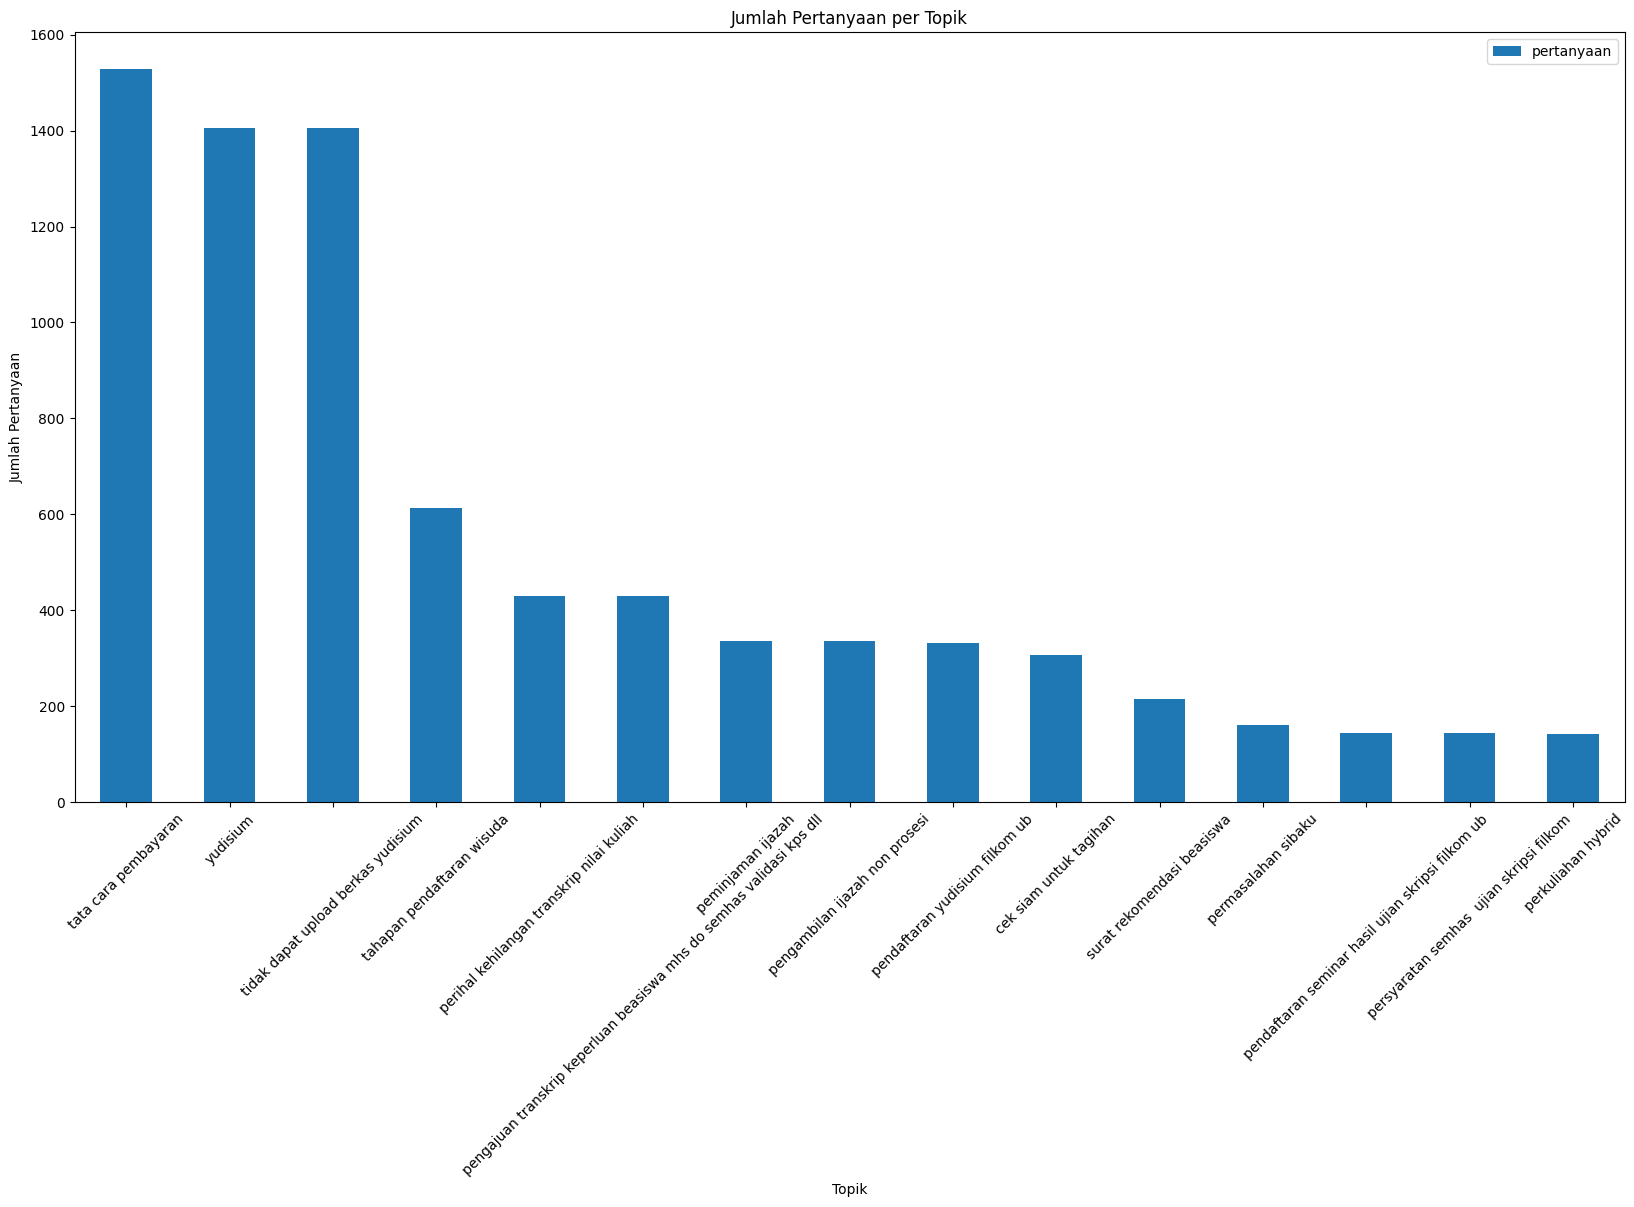

In [45]:
dfp =dfg.head(15).plot(kind='bar',
            figsize=(20,10),
            title='Jumlah Pertanyaan per Topik',
            xlabel='Topik',
            ylabel='Jumlah Pertanyaan',
            rot=45)

In [46]:
fig = dfp.get_figure()
fig.savefig("experiment_n2.png")

### Cleaning

In [47]:
dfPertanyaan['pertanyaan'] = dfPertanyaan['pertanyaan'].apply(lambda x: x.replace('\u00a0',''))

In [48]:
dfPertanyaan.to_csv('pertanyaan_n2.csv', index=False)

## Intent Classification

In [49]:
intents = dict()
intents['intents'] = []

In [63]:
for i in range(len(df)):
    print(df['topik'][i])
    

Keuangan  - Pengajuan Bantuan Keuangan
Keuangan - Pencairan Saldo UKT
keuangan - cek siam untuk tagihan
Keuangan - Kriteria 50%
Registrasi Mahasiswa Lama
Keuangan - Jadwal Bantuan Keuangan
Keuangan : Tata Cara Pembayaran
Keuangan - Banding UKT Mahasiswa
Keuangan : Terlambat Pengajuan Bantuan Keuangan
Keuangan - Pencairan Beasiswa Kemendikbud
Keuangan : Tidak dapat upload Berkas Yudisium
Keuangan - Bantuan UKT dan UKT Kemendikbud Ristek
Kemahasiswaan - Tahapan pendaftaran Wisuda
Keuangan - Cara Daftar Bantuan Kemendikbud Ristek
Keuangan - Bantuan Kemendikbud tidak terverifikasi
Keuangan - Tagihan UKT POtongan 50% Muncul Kembali
Keuangan - Sisa tagihan 50%
Keuangan - Angsur SAP
Kemahasiswaan - KTM Tersedia
Kemahasiswaan- pengajuan ST Dospem dan Reward Prestasi
Kemahasiswaan - KIP Kuliah
Kemahasiswaan - Verifikasi SKM
Akademik_NIP Khajur KPS TIF
Kemahasiswaan - Rekomendasi magang mandiri dan MBKM
Kemahasiswaan - Pengajuan ST Dosen Pembimbing Lomba
Kemahasiswaan - Rekomendasi Magang dan MB

In [57]:
index = 100
intent = dict()
topik = " ".join(dfKeywords['topik'][index].split())
correspPertanyaan = dfPertanyaan.index[dfPertanyaan['topik'] == topik].tolist()
pattern_question = []
for i in correspPertanyaan:
    text = dfPertanyaan['pertanyaan'][i]
    pattern_question.append(text)

print(topik)
print([df['jawaban'][index]])
# print(pattern_question)

nilai mbkm belum keluar 20212
['Terimakasih telah menghubungi halo filkom,Menginfokan terkait perkuliahan yg telah berjalan s.d UTS sekarang, maka jika terdapat mahasiswa dengan kelas non hyid dan berhalangan untuk mengikuti secara luring dimohon mengisi Form berikut ini sbg pendataan akademik fakultas s.d jumat 08 04 2022 :https://docs.google.com/forms/d/e/1FAIpQLSfN_-ptPujRNgvv9Up9ZnjRp64w8RqeS7_BO4XAhzl95u0HyA/viewform" target="_blankhttps://docs.google.com/forms/d/e/1FAIpQLSfN_-ptPujRNgvv9Up9ZnjRp64w8RqeS7_BO4XAhzl95u0HyA/viewform Terimakasih']


In [51]:
for j in range(len(dfKeywords)):
    index = j
    intent = dict()
    topik = " ".join(dfKeywords['topik'][index].split())
    correspPertanyaan = dfPertanyaan.index[dfPertanyaan['topik'] == topik].tolist()
    pattern_question = []
    for i in correspPertanyaan:
        text = dfPertanyaan['pertanyaan'][i]
        pattern_question.append(text)

    # remove duplicates pattern_question
    pattern_question = list(dict.fromkeys(pattern_question))

    intent['tag'] = topik.replace(' ','_').replace('__','_')
    intent['patterns'] = pattern_question
    intent['responses'] = [df['jawaban'][index]]
    intents['intents'].append(intent)


### Add intent salam, tutup, no_respon

In [53]:
salam_intent = {
            "tag":"sapaan",
            "patterns": [
                "halo",
                "selamat siang",
                "selamat malam",
                "selamat pagi",
                "salam"
            ],
            "responses": [
                "Halo, saya disini HaloFILKOM Bot akan membantu anda dalam menjawab pertanyaan anda untuk urusan kemahasiswaan dan akademik."
            ]
        }
intents['intents'].append(salam_intent)

penutup_intent = {
            "tag":"penutup",
            "patterns": [
                "terima kasih",
                "menjawab",
                "sudah menjawab",
                "cukup"
            ],
            "responses": [
                "Terima kasih telah menggunakan layanan HaloFILKOM Bot, jika ada hal hal yang ingin ditanyakan lebih lanjut jangan ragu menghubungi saya lagi. Have a good day."
            ]
        }
intents['intents'].append(penutup_intent)


no_res_intent = {
            "tag":"no_response",
            "patterns": [],
            "responses": [
                "Pertanyaan belum saya kenali... silahkan menghubungi unit terkait untuk menjawab pertanyaan tersebut di HaloFILKOM. Anda juga dapat menambahkan pertanyaan anda pada <a href='https://s.ub.ac.id/tanyafilkombot' target='_blank'>laman berikut</a> untuk membantu mengembangkan sistem ini"
            ]
        }
intents['intents'].append(no_res_intent)

### Export intent to json

In [54]:
import json

with open ('intents_new.json', 'w') as outfile:
# with open ('intents_top15.json', 'w') as outfile: 
# with open ('intents_tes50.json', 'w') as outfile: 
# with open ('intents_coba.json', 'w') as outfile:
    json.dump(intents, outfile)